<a href="https://colab.research.google.com/github/JARVIS-Materials-Design/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/ALIGNN_PhononDOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rapid Prediction of Phonon Structure and Properties using an Atomistic Line Graph Neural Network (ALIGNN)

Refs:1) https://arxiv.org/abs/2207.12510,
2) https://www.nature.com/articles/s41524-021-00650-1

In [1]:
!pip install alignn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [2]:
from alignn.pretrained import  get_prediction,get_figshare_model
from jarvis.analysis.phonon.dos import PhononDos
from jarvis.db.figshare import get_jid_data
from jarvis.core.atoms import Atoms
from jarvis.core.graphs import Graph
import numpy as np 
import torch
#Ce: JVASP-14640
atoms=Atoms.from_dict(get_jid_data(jid='JVASP-14640',dataset='dft_3d')['atoms'])
model=get_figshare_model('jv_pdos_alignn')

device = "cpu"
# if torch.cuda.is_available():
#     device = torch.device("cuda")
model.to(device)
cutoff = 8
max_neighbors = 12
g, lg = Graph.atom_dgl_multigraph(
    atoms, cutoff=float(cutoff), max_neighbors=max_neighbors,
)
out_data = (
    model([g.to(device), lg.to(device)])
    .detach()
    .cpu()
    .numpy()
    .flatten()
    .tolist()
)
ph_dos = np.array(out_data)
ph_dos[ph_dos<0]=0
phonon_freq_cm=np.linspace(-300,1000,66)
ph_dos = ph_dos[phonon_freq_cm>0]
phonon_freq_cm = phonon_freq_cm[phonon_freq_cm>0]


f=open('ph_dos_data.csv','w')
f.write('Frequency_cm,DOS\n')
for i,j in zip(phonon_freq_cm,ph_dos):
    line = str(i)+','+str(j)+'\n'
    f.write(line)
f.close()

ph=PhononDos(phonon_dos=ph_dos,phonon_freq_cm=phonon_freq_cm)
debye_temp = ph.debye_temperature(atoms)
print ('debye_temp',debye_temp)

Obtaining 3D dataset 55k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.
Using chk file jv_pdos_alignn/checkpoint_599.pt from  ['jv_pdos_alignn/checkpoint_600.pt', 'jv_pdos_alignn/checkpoint_599.pt']
Path /usr/local/lib/python3.7/dist-packages/alignn/jv_pdos_alignn.zip
debye_temp 220.76401711949438


In [3]:
print(atoms)

Ce
1.0
2.883577080372866 -0.0 1.6648337892833467
0.9611923601242888 2.7186624460117796 1.6648337892833467
0.0 -0.0 3.3296675785666934
Ce
1
Cartesian
0.0 0.0 0.0



In [4]:
!pip uninstall -y matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
alignn 2022.9.22 requires matplotlib>=3.4.1, but you have matplotlib 3.1.3 which is incompatible.


Text(0, 0.5, 'DOS')

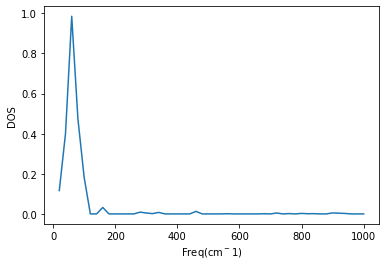

In [5]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(phonon_freq_cm,ph_dos)
plt.xlabel('Freq(cm$^-1$)')
plt.ylabel('DOS')
